# ResNet-Based mmFace

In [1]:
import torch
import torch.nn as nn
# from torchvision.models import resnet18, ResNet18_Weights
# from torchvision.models import resnet50
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_classes = 19

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=50):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        layers = [block(self.inplanes, planes, stride, downsample)] + [block(planes, planes) for _ in range(blocks-1)]
        self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # TODO: MAYBE STOP HERE FOR 512D EMBEDDING???
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class MMFace(nn.Module):
    def __init__(self, num_classes=50):
        super(MMFace, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3)
        self.fc = nn.Linear(1536, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

cuda


## Loading Dataset and Model

In [2]:
from dataset_builder import normalise, load_dataset
from torchvision.transforms import Compose, ToTensor
import os
import numpy as np

def load_model(name, model, optimiser):
    epoch = 0
    loss_history, train_acc, val_acc = [], [], []
    try:
        checkpoint = torch.load(f"models/{name}")
        model.load_state_dict(checkpoint["model_state_dict"])
        optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
        epoch = checkpoint["epoch"]
        loss_history = checkpoint["loss_history"]
        train_acc = checkpoint["train_acc"]
        val_acc = checkpoint["val_acc"]
    except Exception as ex:
        print(ex)
    
    return epoch, loss_history, train_acc, val_acc

def load_history(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint["loss_history"], checkpoint["train_acc"], checkpoint["val_acc"]

frames = 250
train, validation, test = load_dataset(os.path.relpath("../../Soli/soli_realsense/data"), range(num_classes), transform=Compose([normalise, ToTensor()]))

100%|██████████| 19/19 [00:13<00:00,  1.45it/s]

True


## Hyperparameters + Loss + Optimiser

In [3]:
# from cnn import MMFace_Padding, MMFace

num_epochs = 80
learning_rate = 0.01

# model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes).to(device)
model = MMFace(num_classes).to(device)

# model = resnet18(weights=ResNet18_Weights.DEFAULT)
# model = resnet50()
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = "mmFace250-no_padding.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)
# for param in model.parameters():
#     param.requires_grad = True

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]:.4f}\n\tValidation Accuracy: {val_acc[-1]:.4f}")

[Errno 2] No such file or directory: 'models/mmFace250-no_padding.pt'


## Training
- Load training data in ***batches*** for every epoch, moving to `device`
  - `train_loader` = `[([data*], [labels*])*]`
- `model(data)` to predict label, then calculate loss between predictions and ground truth labels using `criterion(preds, labels)`
- Backpropagate to learn with `loss.backward()`, and update weights with `optimiser.step()`. Gradients must be reset to 0 after every update with `optimiser.zero_grad()` otherwise gradients will accumulate (default PyTorch).
- After every epoch, test model on validation set but can turn off gradients for faster evaluation using `with torch.no_grad()`.

In [4]:
import gc

for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if len(loss_history) > 0:
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc, total = 0., 0., 0.

    for data, labels in tqdm(train):
        data = data.to(device)
        labels = labels.to(device)

        # Forward Pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total += labels.size(0)
        running_acc += (predicted == labels).sum().item()

        del data, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc = 100*running_acc/total
    print(f"\tLatest Train Loss: {loss.item():.4f}")
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy: {avg_train_acc:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [avg_train_acc],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    print("Validation")
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in tqdm(validation):
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del data, labels, outputs
        
        avg_val_acc = 100*correct/total
        print(f"\tValidation Accuracy: {avg_val_acc:.4f}%")

    model_checkpoint = torch.load(f"models/{model_name}")
    model_checkpoint["val_acc"].append(avg_val_acc)
    torch.save(model_checkpoint, f"models/{model_name}")


Epoch [0/79]:


100%|██████████| 1782/1782 [10:53<00:00,  2.73it/s]


	Latest Train Loss: 3.0477
	Average Train Loss: 2.8688
	Train Accuracy: 8.7689%
Validation


100%|██████████| 223/223 [00:10<00:00, 21.47it/s]


	Accuracy of mmFace: 10.0772%

Epoch [1/79]:


100%|██████████| 1782/1782 [10:37<00:00,  2.79it/s]


	Latest Train Loss: 3.0512
	Average Train Loss: 2.8216
	Train Accuracy: 10.2304%
Validation


100%|██████████| 223/223 [00:10<00:00, 21.95it/s]


	Accuracy of mmFace: 10.2877%

Epoch [2/79]:


100%|██████████| 1782/1782 [11:22<00:00,  2.61it/s]


	Latest Train Loss: 2.1880
	Average Train Loss: 2.8034
	Train Accuracy: 11.1620%
Validation


100%|██████████| 223/223 [00:10<00:00, 20.53it/s]


	Accuracy of mmFace: 10.9193%

Epoch [3/79]:


100%|██████████| 1782/1782 [11:18<00:00,  2.63it/s]


	Latest Train Loss: 3.0188
	Average Train Loss: 2.7893
	Train Accuracy: 11.7182%
Validation


100%|██████████| 223/223 [00:10<00:00, 20.47it/s]


	Accuracy of mmFace: 10.6526%

Epoch [4/79]:


 37%|███▋      | 661/1782 [04:04<06:50,  2.73it/s]

## Testing

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in tqdm(test):
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
        del data, labels, outputs
    
    print(f"Test Accuracy of mmFace: {100*correct/total:.4f}%")

100%|██████████| 211/211 [00:16<00:00, 13.00it/s]

Test Accuracy of mmFace: 10.1481%


# Evaluation

In [44]:
def frequency(dataset, name):
    freq = torch.zeros(num_classes).to(device)
    for _, subjects in tqdm(dataset):
        subjects = subjects.to(device)
        for i in range(num_classes):
            freq[i] += torch.count_nonzero(subjects == i)
    print(f"{name} Distribution: {freq.cpu().numpy()}")

# frequency(train, "Train")
frequency(validation, "Validation")
frequency(test, "Test")

100%|██████████| 200/200 [01:19<00:00,  2.51it/s]


Validation Distribution: [364. 389. 402. 333. 381. 400. 372. 356. 389. 360. 374. 389. 360. 372.
 384. 359. 390.]


100%|██████████| 200/200 [01:15<00:00,  2.65it/s]

Test Distribution: [420. 367. 363. 385. 359. 368. 402. 374. 391. 376. 371. 376. 357. 359.
 355. 365. 388.]


[9.511639535529751, 37.296516473137395]
[10.488888888888889, 10.444444444444445]
[2.7518794536590576, 2.842050313949585]


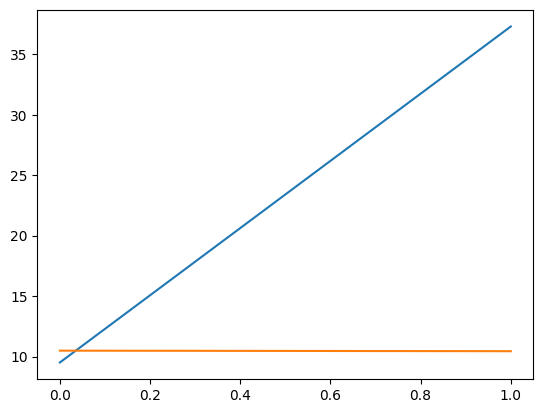

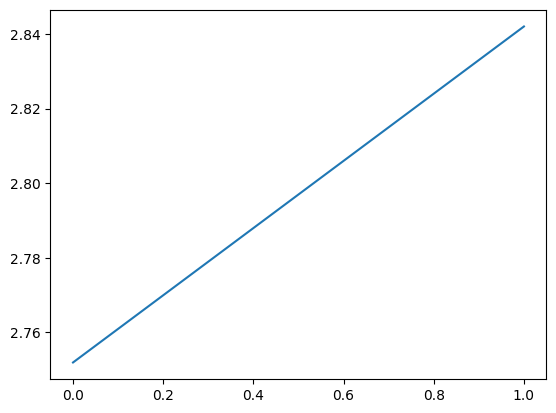

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

model_checkpoint = torch.load(f"models/{model_name}")
losses = model_checkpoint["loss_history"]
train_acc = model_checkpoint["train_acc"]
val_acc = model_checkpoint["val_acc"]

plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(val_acc)), val_acc)
plt.figure()

plt.plot(range(len(losses)), losses)
plt.figure()

print(train_acc)
print(val_acc)
print(losses)

<Axes: >

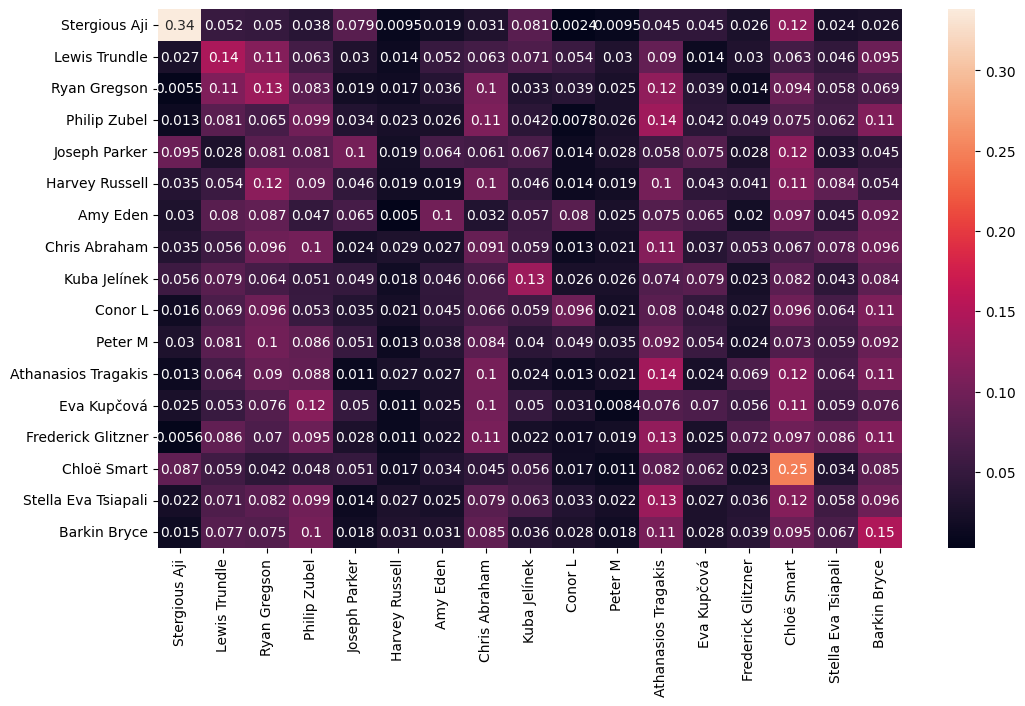

In [52]:
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

# subjects = anon_names
subjects = range(num_classes)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subjects, columns=subjects)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

# Evaluation

<Axes: >

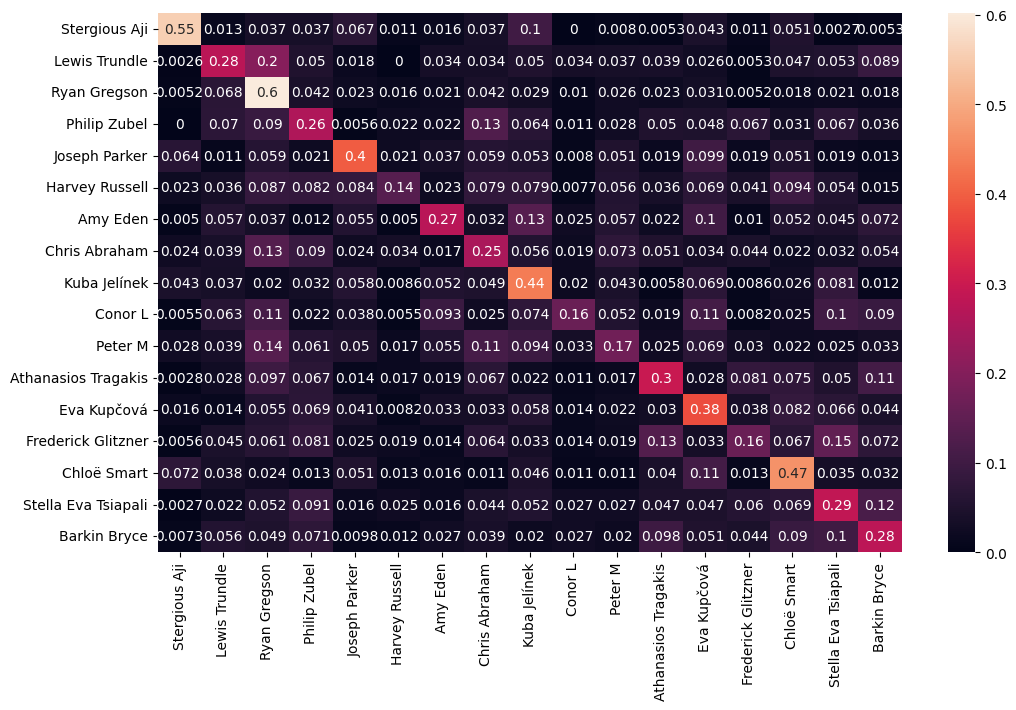

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) # Feed Network

        _, predicted = torch.max(outputs.data, 1)
        # predicted = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        predicted = predicted.cpu().numpy()
        y_pred.extend(predicted) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in anon_names],
                     columns = [i for i in anon_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)